# COS20083 Advanced Data Analytics

## Assignment 2: Case Study and Algorithm Implementation

### Semester 1, 2021

#### Group Number: <p style ="color: blue;">08</p>
#### Group Members: <p style ="color: blue;">Clement Goh Yung Jing</p> <p style ="color: blue;">Arthur Vincent Chin</p>

## <p style ="color: blue;">1. Introduction</p>

The problem that exist and needs to be addressed is the number of new properties in Malaysia keeps increasing and the ability to determine whether the particular property is undervalued at the moment such that it is worth investing is difficult as the value of a property can be affected by a lot of factors. The rise of several new properties at a time can make the ability to decide if a property is valuable difficult as well. The stakeholders that are involved in this study are the property or real estate investors. Presently, there are a lot of property forecaster that utlises tools that help them analyse the value of a property. 

Therefore, the purpose and objective is to build a suypervised learning model in order to help the investor to determine which newly launched property is worth investing. In this assignment, the properties are narrowed down to the condominiums in Kuala Lumpur (KL) specifically. The model built at the end shall be able to provide recommendation to property investor to suggest the properties that are worth investing. 

## <p style ="color: blue;">2. Data Collection</p>

In order to build a learning model to help determine which newly launched property is worth investing, the data of the past properties will need to be gathered first. The method used in this assignment is web scraping. By web scraping the property listing sites online, the properties listed on the website along with its information such as the name, price, facilities avaialble as well as some other details of the property such as number of bedrooms and bathrooms, area of the property etc, will be sourced and gathered into a single file to be learned by the model. These data are crucial as they will be the one responsible to build an accurate model that predicts the value of the newly launched properties specifically the condominiums in KL in this case.

Firstly, the website to be used as the source of the data will need to be determined. In this case, www.propsocial.com will be used as the information displayed in each property is more detailed and complete which will help the model to learned all the variables that affects the value of a particular property. Next, several Python libraries will be used to extract the HTML source code of the webpage as well as extract the HTML elements that contains the important information such as the basic attributes of the property (names, price, area, no of bedrooms and bathrooms etc) and the facilities available in that property. 

The flow of the process of web scraping is as follows. The webpage will first be retrieved and the text of all the HTML elements that contains the information needed will be stored into a list. Some basic cleaning and trimming will be performed to the elements in all the list in order to remove all the unnecessary empty leading and trailing spaces as well as the HTML symbol codes. The links to the property information page will also be retrieved  and stored into a list in order to extract number of facilities available in that property.

The attributes of the properties are retreived from the result of the search in the website, then to get the link to the property info page, each property listed webpage will be browsed. After that, the link to the property info page will be gathered and stored to a list named `linksToProperty`. This procedure will then be repeated to 50 webpages with an interval of 20. This is to get enough data from the older dates to train the model using the data prior 2021.

Next, the property info pages will be browsed one by one to get the total count of the facilities available in each property. The count will be stored into a list as well. The lists storing the information are summarised as below.

 Name of list   | Description
 ---------------|-------------
`names`          | Names of the property
`prices`         | Price listed of the property
`tenures`        | Type of tenure (Freehold/Leasehold)
`categories`     | Type of property
`furnishes`      | Type of furnished level (Fully/Semi/Unfurnished)
`sqfts`          | Area of property in square feet
`bedrooms`       | Number of bedrooms
`bathroom`       | Number of bathrooms
`dates`          | Date last updated/listed
`linksToProperty`| Link to the property individual listing page


All the lists will then be transformed into a Pandas dataframe and exported into a csv file named "prop.csv".

In [ ]:
# import all necessary libraries
import requests
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
plt.style.use("seaborn-white")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Demonstration for extracting properties data from first page

In [ ]:
# link to the first search result page
url = "https://www.propsocial.my/buy/kuala-lumpur-33?category[]=Condominium&page=1"

In [ ]:
# using requests to retrieve the webpage and display it
page = requests.get(url)
soup = BeautifulSoup(page.content, 'html.parser')
print(soup.prettify())

<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">
<html lang="en" xml:lang="en" xmlns="http://www.w3.org/1999/xhtml">
 <head prefix="og: http://ogp.me/ns# fb: http://ogp.me/ns/fb# place: http://ogp.me/ns/place#">
  <link href="/manifest.json" rel="manifest"/>
  <link href="https://pagead2.googlesyndication.com" rel="preconnect"/>
  <link href="https://www.googleadservices.com" rel="preconnect"/>
  <link href="https://www.google-analytics.com" rel="preconnect"/>
  <link href="https://pagead2.googlesyndication.com" rel="dns-prefetch"/>
  <link href="https://www.googleadservices.com" rel="dns-prefetch"/>
  <link href="https://www.google-analytics.com" rel="dns-prefetch"/>
  <link href="https://connect.facebook.net" rel="preconnect"/>
  <link href="https://platform.twitter.com" rel="preconnect"/>
  <link href="https://www.facebook.com" rel="preconnect"/>
  <link href="https://connect.facebook.net" rel="dns-prefetch"/>


In [ ]:
# initialise all the features into an empty list
names, prices, tenures, categories, furnishes, sqfts, bedrooms, bathrooms, dates = [], [], [], [], [], [], [], [], []
linksToProperty = []

In [ ]:
# extract out all the features from the webpage

# for all the <div class = "classified-ad-box-ad"> elements
for a in soup.findAll('div', attrs={'class':'classified-ad-box-ad'}):
    
    # if the element contains the price of the property
    if a.find('div', attrs={'class':'pricing'}):
        name = a.find('div', attrs={'class':'classified-ad-details'}).div.h3.a #get the name element
        price = a.find('div', attrs={'class':'pricing'}).span.a # get the price element
        
        tenure = a.find('div', attrs={'class':'classified-ad-specific-detail'}) # get the tenure element
        category = tenure.findNext('div', attrs={'class':'classified-ad-specific-detail'}) # get the category element
        sqft = category.findNext('div', attrs={'class':'classified-ad-specific-detail'}) # get the sqft element
        furnish = sqft.findNext('div', attrs={'class':'classified-ad-specific-detail'}) # get the furnish element
        bedroom = furnish.findNext('div', attrs={'class':'classified-ad-specific-detail'}) # get the bedroom num element
        bathroom = bedroom.findNext('div', attrs={'class':'classified-ad-specific-detail'}) # get the bathroom num element
        date = a.find('span', attrs={'class':'classified-ad-timespan'}) # get the date element
        
        url2 = "https://www.propsocial.my/" + str(name['href']) # get the link navigable element in the name
        
        # get the webpage to the individual property listing page
        page2 = requests.get(url2)
        soup2 = BeautifulSoup(page2.content, 'html.parser')
        
        propPage = soup2.find('div', attrs={'class':'neighbourhood-see-more-details'})
        linkToProperty = propPage.findNext('div', attrs={'class':'neighbourhood-see-more-details'}).find('a', href = True)['href'] # get the link to the property info page
        
        linksToProperty.append("https://www.propsocial.my/" + str(linkToProperty)) # store link into list
        
        # add the features extracted into their respective lists
        names.append(name.text)
        prices.append(price.text)
        tenures.append(tenure.text)
        categories.append(category.text)
        furnishes.append(furnish.text)
        sqfts.append(sqft.text)
        bedrooms.append(bedroom.text)
        bathrooms.append(bathroom.text)   
        dates.append(date.text)

In [ ]:
# links to the detail of each properties
linksToProperty

['https://www.propsocial.my//developments/midfields-838',
 'https://www.propsocial.my//developments/taman-desa-petaling-7523',
 'https://www.propsocial.my//developments/you-city-4370',
 'https://www.propsocial.my//developments/d-brightton-11334',
 'https://www.propsocial.my//developments/platinum-lake-pv10-1320',
 'https://www.propsocial.my//developments/idaman-puteri-1881',
 'https://www.propsocial.my//developments/idaman-sutera-1882',
 'https://www.propsocial.my//developments/11-mont-kiara-153',
 'https://www.propsocial.my//developments/vista-komanwel-406',
 'https://www.propsocial.my//developments/star-residences-5155',
 'https://www.propsocial.my//developments/segar-courts-5469',
 'https://www.propsocial.my//developments/arte-mont-kiara-5601',
 'https://www.propsocial.my//developments/fortune-avenue-910',
 'https://www.propsocial.my//developments/taman-wangsa-melawati-2463',
 'https://www.propsocial.my//developments/vista-sentul-10739']

In [ ]:
# display all preprocessed data
print(names)
print(prices)
print(tenures)
print(categories)
print(furnishes)
print(sqfts)
print(bedrooms)
print(bathrooms)
print(dates)

['\n          Midfields, Sungai Besi\n', '\n          Taman Desa Petaling, Desa Petaling\n', '\n          You City, Batu 9 Cheras\n', "\n          d'Brightton, Setapak\n", '\n          Platinum Lake PV10, Setapak\n', '\n          Idaman Puteri, Setapak\n', '\n          Idaman Sutera, Setapak\n', '\n          11 Mont Kiara, Mont Kiara\n', '\n          Vista Komanwel, Bukit Jalil\n', '\n          Star Residences, Kuala Lumpur\n', '\n          Segar Courts, Cheras\n', '\n          Arte Mont Kiara, Dutamas\n', '\n          Fortune Avenue, Kepong\n', '\n          Taman Wangsa Melawati, Wangsa Maju\n', '\n          Vista Sentul, Sentul\n']
['For Sale: RM 510,000', 'For Sale: RM 429,000', 'For Sale: RM 699,000', 'For Sale: RM 1,490,000', 'For Sale: RM 450,000', 'For Sale: RM 750,000', 'For Sale: RM 228,000', 'For Sale: RM 2,850,000', 'For Sale: RM 420,000', 'For Sale: RM 1,280,000', 'For Sale: RM 610,000', 'For Sale: RM 880,000', 'For Sale: RM 400,000', 'For Sale: RM 468,000', 'For Sale: RM 4

In [ ]:
# helper function to clean trim all elements in the list
def clean_trim(List):
    temp = []
    for i in List:
        temp.append(i.strip()) # remove all special characters and space
    return temp

In [ ]:
# clean and trim all lists
names = clean_trim(names)
prices = clean_trim(prices)
tenures = clean_trim(tenures)
categories = clean_trim(categories)
sqfts = clean_trim(sqfts)
furnishes = clean_trim(furnishes)
bedrooms = clean_trim(bedrooms)
bathrooms = clean_trim(bathrooms)
dates = clean_trim(dates)

In [ ]:
# display all processed lists
print(names)
print(prices)
print(tenures)
print(categories)
print(furnishes)
print(sqfts)
print(bedrooms)
print(bathrooms)
print(dates)

['Midfields, Sungai Besi', 'Taman Desa Petaling, Desa Petaling', 'You City, Batu 9 Cheras', "d'Brightton, Setapak", 'Platinum Lake PV10, Setapak', 'Idaman Puteri, Setapak', 'Idaman Sutera, Setapak', '11 Mont Kiara, Mont Kiara', 'Vista Komanwel, Bukit Jalil', 'Star Residences, Kuala Lumpur', 'Segar Courts, Cheras', 'Arte Mont Kiara, Dutamas', 'Fortune Avenue, Kepong', 'Taman Wangsa Melawati, Wangsa Maju', 'Vista Sentul, Sentul']
['For Sale: RM 510,000', 'For Sale: RM 429,000', 'For Sale: RM 699,000', 'For Sale: RM 1,490,000', 'For Sale: RM 450,000', 'For Sale: RM 750,000', 'For Sale: RM 228,000', 'For Sale: RM 2,850,000', 'For Sale: RM 420,000', 'For Sale: RM 1,280,000', 'For Sale: RM 610,000', 'For Sale: RM 880,000', 'For Sale: RM 400,000', 'For Sale: RM 468,000', 'For Sale: RM 466,400']
['Freehold', 'Freehold', 'Freehold', 'Leasehold', 'Freehold', 'Freehold', 'Freehold', 'Freehold', 'Freehold', 'Freehold', 'Leasehold', 'Freehold', 'Freehold', 'Freehold', 'Freehold']
['Condominium', 'C

In [ ]:
# Web scrape for the rest of the data (the rest of the 49 pages since page 1 has been scraped)
for i in range(20, 1001, 20):
    print('Extracting page', i)
    url = "https://www.propsocial.my/buy/kuala-lumpur-33?category[]=Condominium&page=" + str(i)

    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    
    # extract out all the features from the webpage
    # for all the <div class = "classified-ad-box-ad"> elements
    for a in soup.findAll('div', attrs={'class':'classified-ad-box-ad'}):

        # if the element contains the price of the property
        if a.find('div', attrs={'class':'pricing'}):
            name = a.find('div', attrs={'class':'classified-ad-details'}).div.h3.a #get the name element
            price = a.find('div', attrs={'class':'pricing'}).span.a # get the price element
            
            tenure = a.find('div', attrs={'class':'classified-ad-specific-detail'}) # get the tenure element
            category = tenure.findNext('div', attrs={'class':'classified-ad-specific-detail'}) # get the category element
            sqft = category.findNext('div', attrs={'class':'classified-ad-specific-detail'}) # get the sqft element
            furnish = sqft.findNext('div', attrs={'class':'classified-ad-specific-detail'}) # get the furnish element
            bedroom = furnish.findNext('div', attrs={'class':'classified-ad-specific-detail'}) # get the bedroom num element
            bathroom = bedroom.findNext('div', attrs={'class':'classified-ad-specific-detail'}) # get the bathroom num element
            date = a.find('span', attrs={'class':'classified-ad-timespan'}) # get the date element
            
            url2 = "https://www.propsocial.my/" + str(name['href']) # get the link navigable element in the name
            
            # get the webpage to the individual property listing page
            page2 = requests.get(url2)
            soup2 = BeautifulSoup(page2.content, 'html.parser')
            
            propPage = soup2.find('div', attrs={'class':'neighbourhood-see-more-details'})
            linkToProperty = propPage.findNext('div', attrs={'class':'neighbourhood-see-more-details'}).find('a', href = True)['href'] # get the link to the property info page
            
            linksToProperty.append("https://www.propsocial.my/" + str(linkToProperty)) # store link into list
            
            # add the features extracted into their respective lists
            names.append(name.text)
            prices.append(price.text)
            tenures.append(tenure.text)
            categories.append(category.text)
            furnishes.append(furnish.text)
            sqfts.append(sqft.text)
            bedrooms.append(bedroom.text)
            bathrooms.append(bathroom.text)   
            dates.append(date.text)

Extracting page 2
Extracting page 22
Extracting page 42
Extracting page 62
Extracting page 82
Extracting page 102
Extracting page 122
Extracting page 142
Extracting page 162
Extracting page 182
Extracting page 202
Extracting page 222
Extracting page 242
Extracting page 262
Extracting page 282
Extracting page 302
Extracting page 322
Extracting page 342
Extracting page 362
Extracting page 382
Extracting page 402
Extracting page 422
Extracting page 442
Extracting page 462
Extracting page 482
Extracting page 502
Extracting page 522
Extracting page 542
Extracting page 562
Extracting page 582
Extracting page 602
Extracting page 622
Extracting page 642
Extracting page 662
Extracting page 682
Extracting page 702
Extracting page 722
Extracting page 742
Extracting page 762
Extracting page 782
Extracting page 802
Extracting page 822
Extracting page 842
Extracting page 862
Extracting page 882
Extracting page 902
Extracting page 922
Extracting page 942
Extracting page 962
Extracting page 982
Extrac

In [ ]:
len(linksToProperty)

780

In [ ]:
# extarct the number of facilities in each property
facilitiesCount = []

for link in range(len(linksToProperty)):
    print('Extracting page', link + 1)
    
    # retireve the property info page in the list
    page3 = requests.get(linksToProperty[link])
    soup3 = BeautifulSoup(page3.content, 'html.parser')

    # extracting facilities from one property
    facilities = []
    
    # to retrieve all the facilies of a property
    facillityCat = soup3.find('div', attrs={'class':'facility-category'})
    if (facillityCat != None): # check if facilities are available
        facilitiesList = facillityCat.findAll('div', attrs={'class':'col-md-6'}) # get all the facilies element in a column

        for i in facilitiesList:
            # store the 3 available visible facilties
            firstFaci = i.find('div').span # get first facility
            facilities.append(firstFaci.text)

            if (firstFaci.findNext('div').span != None):
                secondFaci = firstFaci.findNext('div').span # get second facility
                facilities.append(secondFaci.text)

                if (secondFaci.findNext('div').span != None):
                    thirdFaci = secondFaci.findNext('div').span # get third facility 
                    facilities.append(thirdFaci.text)

                    # store the hidden facilites
                    for j in i.findAll('div', attrs={'class':'facilities-div'}): # get all the expandable list of facilities
                        facilities.append(j.span.text)

        facilitiesCount.append(len(facilities)) # get the total count of facilities and store into the count list

    else:
        facilitiesCount.append(0) # if no facilities indicated, store 0

Extracting page 1
Extracting page 2
Extracting page 3
Extracting page 4
Extracting page 5
Extracting page 6
Extracting page 7
Extracting page 8
Extracting page 9
Extracting page 10
Extracting page 11
Extracting page 12
Extracting page 13
Extracting page 14
Extracting page 15
Extracting page 16
Extracting page 17
Extracting page 18
Extracting page 19
Extracting page 20
Extracting page 21
Extracting page 22
Extracting page 23
Extracting page 24
Extracting page 25
Extracting page 26
Extracting page 27
Extracting page 28
Extracting page 29
Extracting page 30
Extracting page 31
Extracting page 32
Extracting page 33
Extracting page 34
Extracting page 35
Extracting page 36
Extracting page 37
Extracting page 38
Extracting page 39
Extracting page 40
Extracting page 41
Extracting page 42
Extracting page 43
Extracting page 44
Extracting page 45
Extracting page 46
Extracting page 47
Extracting page 48
Extracting page 49
Extracting page 50
Extracting page 51
Extracting page 52
Extracting page 53
Ex

Extracting page 417
Extracting page 418
Extracting page 419
Extracting page 420
Extracting page 421
Extracting page 422
Extracting page 423
Extracting page 424
Extracting page 425
Extracting page 426
Extracting page 427
Extracting page 428
Extracting page 429
Extracting page 430
Extracting page 431
Extracting page 432
Extracting page 433
Extracting page 434
Extracting page 435
Extracting page 436
Extracting page 437
Extracting page 438
Extracting page 439
Extracting page 440
Extracting page 441
Extracting page 442
Extracting page 443
Extracting page 444
Extracting page 445
Extracting page 446
Extracting page 447
Extracting page 448
Extracting page 449
Extracting page 450
Extracting page 451
Extracting page 452
Extracting page 453
Extracting page 454
Extracting page 455
Extracting page 456
Extracting page 457
Extracting page 458
Extracting page 459
Extracting page 460
Extracting page 461
Extracting page 462
Extracting page 463
Extracting page 464
Extracting page 465
Extracting page 466


In [ ]:
# display the total properties with facilities 
len(facilitiesCount)

780

In [ ]:
# clean and trim for the rest of the lists
names = clean_trim(names)
prices = clean_trim(prices)
tenures = clean_trim(tenures)
categories = clean_trim(categories)
sqfts = clean_trim(sqfts)
furnishes = clean_trim(furnishes)
bedroom = clean_trim(bedrooms)
bathrooms = clean_trim(bathrooms)
dates = clean_trim(dates)

In [ ]:
# display the cleaned lists
print(names)
print(prices)
print(tenures)
print(categories)
print(furnishes)
print(sqfts)
print(bedrooms)
print(bathrooms)
print(dates)

['Midfields, Sungai Besi', 'Taman Desa Petaling, Desa Petaling', 'You City, Batu 9 Cheras', "d'Brightton, Setapak", 'Platinum Lake PV10, Setapak', 'Idaman Puteri, Setapak', 'Idaman Sutera, Setapak', '11 Mont Kiara, Mont Kiara', 'Vista Komanwel, Bukit Jalil', 'Star Residences, Kuala Lumpur', 'Segar Courts, Cheras', 'Arte Mont Kiara, Dutamas', 'Fortune Avenue, Kepong', 'Taman Wangsa Melawati, Wangsa Maju', 'Vista Sentul, Sentul', 'Tria Residences @ 9 Seputeh, Old Klang Road', 'Taman Pertama, Cheras', 'Tria Residences @ 9 Seputeh, Old Klang Road', 'The Nest 2, Old Klang Road', 'Taman Pertama, Cheras', 'The Como, Bukit Jalil', 'The Como, Bukit Jalil', 'The Rosewoodz Residences, Bukit Jalil', '216 Residences, Kuchai Lama', 'The Address, Taman Desa', 'The Hermington, Kuchai Lama', 'Tria Residences @ 9 Seputeh, Old Klang Road', 'Sunway Velocity TWO, Cheras', 'Taman Pertama, Cheras', 'Tria Residences @ 9 Seputeh, Old Klang Road', 'Binjai Residency, KLCC', 'Residensi Kerinchi, Bangsar South', '

In [ ]:
# combine all lists into a dataframe
prop = {'Name': names,
       'Price': prices,
       'Tenure': tenures,
       'Category': categories,
        'Area': sqfts,
       'Furnish': furnishes,
       'Bedrooms': bedrooms,
       'Bathrooms': bathrooms,
        'Date' : dates,
        'Facilities': facilitiesCount}

df = pd.DataFrame(prop, columns = prop.keys())

# export to csv
df.to_csv('prop.csv', index = False, encoding = 'utf-8')
#df.to_csv('/content/drive/MyDrive/ADA/prop.csv', index = False)

## <p style ="color: blue;">3. Exploratory Data Analysis</p>

Exploratory Data Analysis (EDA) refers to the critical process of performing initial investigations on data so as to discover patterns,to spot anomalies,to test hypothesis and to check assumptions with the help of summary statistics and graphical representations. Before performing any model building or study, it is a good practice to understand the data first and try to gather as many insgihts form it. The process of EDA is to try making sense of the data. However, before performing any analysis, it is also required to process the data to get rid of any outliers as well as clean the data and transform them into approriate format to proceed with the analysis.

Firstly, for the data preprocessing, the csv is imported and stored into the df variable. There is no need to rename the column names as there are all names appropriately when creating the csv file. The content of each column is analysed and cleaned appropriately. For the Price column, the "For Sale: RM" and "," are removed as only the numeric value is needed and the same applies to Area column where the "SQ. FT" and "," are removed to keep the numeric values only. As for the Bedrooms and Bathrooms columns, the word "Bedrooms" and "Bathrooms" as well as "+" are removed then, the ones with "+" previously will be summed up to get a single digit value. For the Date column, "Last Updated at' is removed. Subsequently, all the processed columns are converted into appropriate datatype such as int and datetime. 

Rows with properties with 0 and "Auction" in price are removed as there is no way to predict the price of those properties. The category columnis also removed as all the propoerties categories are all condominium. Hence, this column will not be used in the model.

To convert the categorical values into proper values to be inputed into the model, dummy variables have been created to store 'Tenure' and 'Furnish' columns' values. The tables below shows the converted values.

 Tenure   | Tenure1
 ---------|--------
Freehold  |⠀⠀⠀0
Leasehold |⠀⠀⠀1

Furnish         | Fully | Semi | No
----------------|-------|------|---
Fully Furnished |⠀  1   |⠀  0  |⠀0 
Semi Furnished  |⠀  0   |⠀  1  |⠀0 
Unfurnished     |⠀  0   |⠀  0  |⠀1  




After pre-processed the dataset, a summary statistics of all the columns in the dataframe is generated. This allows the outliers to be identified if there is any. Next, a scatter plot of Price against Area is plotted and there is an outlier with extreme values that can potentially affect the overall result is identified. It is located at row 675 and that row is removed. 

Next, a correlation matrix is plotted to evaluate the correlation between each feature. A heatmap is plotted to view the relationship of each predictor to the response which is the price. Then, a histogram is plotted for each numerical predictor to check their normality and linearity of the variables, and bar chart is plotted for each categorical predictor to view the distribution of the data. A scatter plot is also plotted to view the relationship between each feature with price.

In [ ]:
df = pd.read_csv('prop.csv')
df.head()

/content/drive/MyDrive/ADA


,Name,Price,Tenure,Category,Area,Furnish,Bedrooms,Bathrooms,Date,Facilities
0,"Midfields, Sungai Besi","For Sale: RM 510,000",Freehold,Condominium,"1,074 SQ. FT",Semi Furnished,3 Bedrooms,2 Bathrooms,Last Updated at 13-May-2021,8
1,"Taman Desa Petaling, Desa Petaling","For Sale: RM 429,000",Freehold,Condominium,"1,140 SQ. FT",Fully Furnished,3 Bedrooms,3 Bathrooms,Last Updated at 13-May-2021,0
2,"You City, Batu 9 Cheras","For Sale: RM 699,000",Freehold,Condominium,"1,460 SQ. FT",Fully Furnished,4 Bedrooms,3 Bathrooms,Last Updated at 13-May-2021,18
3,"d'Brightton, Setapak","For Sale: RM 1,490,000",Leasehold,Condominium,"2,927 SQ. FT",Unfurnished,4 + 1 Bedrooms,5 Bathrooms,Last Updated at 13-May-2021,58
4,"Platinum Lake PV10, Setapak","For Sale: RM 450,000",Freehold,Condominium,"1,272 SQ. FT",Fully Furnished,4 Bedrooms,2 Bathrooms,Last Updated at 13-May-2021,14


In [ ]:
# Data preprocessing

for i in range(len(df)):

    # process Price column
    df.loc[i, 'Price'] = df.loc[i, 'Price'].replace(',', '').replace('For Sale: RM', '').strip()
    
    # process Area columnm
    df.loc[i, 'Area'] = df.loc[i, 'Area'].replace(',', '').replace('SQ. FT', '').strip() 
        
    # process Bedrooms column
    df.loc[i, 'Bedrooms'] = df.loc[i, 'Bedrooms'].replace('Bedrooms', '').strip()
    
    # process Bathrooms column
    df.loc[i, 'Bathrooms'] = df.loc[i, 'Bathrooms'].replace('Bathrooms', '').strip()
    
    # process Date column
    df.loc[i, 'Date'] = df.loc[i, 'Date'].replace('Last Updated at', '').strip()
    
    # replace the bedrooms and bathrooms with format such as '3 + 1', '4 + 1' etc and add the two digits together
    if '+' in df.loc[i, 'Bedrooms']:
        df.loc[i, 'Bedrooms'] = df.loc[i, 'Bedrooms'].replace('+', '').strip()
        df.loc[i, 'Bedrooms'] = int(df.loc[i, 'Bedrooms'][0:1]) + int(df.loc[i, 'Bedrooms'][3:4])
        
    if '+' in df.loc[i, 'Bathrooms']:
        df.loc[i, 'Bathrooms'] = df.loc[i, 'Bathrooms'].replace('+', '').strip()
        df.loc[i, 'Bathrooms'] = int(df.loc[i, 'Bathrooms'][0:1]) + int(df.loc[i, 'Bathrooms'][3:4])
          
    # Creating dummy variables for all categorical variables
    # Freehold = 0, Leasehold = 1
    if df.loc[i, 'Tenure'] == 'Freehold':
        df.loc[i, 'Tenure1'] = '0'
    elif df.loc[i, 'Tenure'] == 'Leasehold':
        df.loc[i, 'Tenure1'] = '1'

    # Fully Furnished = Fully - 1, Semi Furnished = Semi - 1, Unfurnished = No - 1
    if df.loc[i, 'Furnish'] == 'Fully Furnished':
        df.loc[i, 'Fully'] = '1'
        df.loc[i, 'Semi'] = '0'
        df.loc[i, 'No'] = '0'
    elif df.loc[i, 'Furnish'] == 'Semi Furnished':
        df.loc[i, 'Fully'] = '0'
        df.loc[i, 'Semi'] = '1'
        df.loc[i, 'No'] = '0'
    elif df.loc[i, 'Furnish'] == 'Unfurnished':
        df.loc[i, 'Fully'] = '0'
        df.loc[i, 'Semi'] = '0'
        df.loc[i, 'No'] = '1'

    if 'Auction' in df.loc[i, 'Price']:
        df = df.drop(i, axis = 0)
        
df.head()

,Name,Price,Tenure,Category,Area,Furnish,Bedrooms,Bathrooms,Date,Facilities,Tenure1,Fully,Semi,No
0,"Midfields, Sungai Besi",510000,Freehold,Condominium,1074,Semi Furnished,3,2,13-May-2021,8,0,0,1,0
1,"Taman Desa Petaling, Desa Petaling",429000,Freehold,Condominium,1140,Fully Furnished,3,3,13-May-2021,0,0,1,0,0
2,"You City, Batu 9 Cheras",699000,Freehold,Condominium,1460,Fully Furnished,4,3,13-May-2021,18,0,1,0,0
3,"d'Brightton, Setapak",1490000,Leasehold,Condominium,2927,Unfurnished,5,5,13-May-2021,58,1,0,0,1
4,"Platinum Lake PV10, Setapak",450000,Freehold,Condominium,1272,Fully Furnished,4,2,13-May-2021,14,0,1,0,0


In [ ]:
# To check if No is equal to 1 when Furnish = Unfurnished
df.loc[df['Furnish'] == 'Unfurnished'].head()

,Name,Price,Tenure,Category,Area,Furnish,Bedrooms,Bathrooms,Date,Facilities,Tenure1,Fully,Semi,No
3,"d'Brightton, Setapak",1490000,Leasehold,Condominium,2927,Unfurnished,5,5,13-May-2021,58,1,0,0,1
6,"Idaman Sutera, Setapak",228000,Freehold,Condominium,845,Unfurnished,3,2,13-May-2021,14,0,0,0,1
12,"Fortune Avenue, Kepong",400000,Freehold,Condominium,1174,Unfurnished,3,2,13-May-2021,14,0,0,0,1
13,"Taman Wangsa Melawati, Wangsa Maju",468000,Freehold,Condominium,1000,Unfurnished,4,2,13-May-2021,1,0,0,0,1
14,"Vista Sentul, Sentul",466400,Freehold,Condominium,960,Unfurnished,3,2,13-May-2021,18,0,0,0,1


In [ ]:
# Convert the columns to the appropriate datatype
df['Price'] = df['Price'].astype(int)
df['Area'] = df['Area'].astype(int)
df['Bedrooms'] = df['Bedrooms'].astype(int)
df['Bathrooms'] = df['Bathrooms'].astype(int)
df['Facilities'] = df['Facilities'].astype(int)
df['Tenure1'] = df['Tenure1'].astype(int)
df['Fully'] = df['Fully'].astype(int)
df['Semi'] = df['Semi'].astype(int)
df['No'] = df['No'].astype(int)
df['Date'] = pd.to_datetime(df['Date'])

# remove unused column
df = df.drop('Category', axis = 1)
# reorder the index of df after removing all the rows
df = df.reset_index(drop=True)

In [ ]:
df.head()

,Name,Price,Tenure,Area,Furnish,Bedrooms,Bathrooms,Date,Facilities,Tenure1,Fully,Semi,No
0,"Midfields, Sungai Besi",510000,Freehold,1074,Semi Furnished,3,2,2021-05-13,8,0,0,1,0
1,"Taman Desa Petaling, Desa Petaling",429000,Freehold,1140,Fully Furnished,3,3,2021-05-13,0,0,1,0,0
2,"You City, Batu 9 Cheras",699000,Freehold,1460,Fully Furnished,4,3,2021-05-13,18,0,1,0,0
3,"d'Brightton, Setapak",1490000,Leasehold,2927,Unfurnished,5,5,2021-05-13,58,1,0,0,1
4,"Platinum Lake PV10, Setapak",450000,Freehold,1272,Fully Furnished,4,2,2021-05-13,14,0,1,0,0


In [ ]:
for i in range(len(df)):
    # remove rows with 0 price
    if df.loc[i, 'Price'] == 0:
        df = df.drop(i, axis = 0)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 759 entries, 0 to 763
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Name        759 non-null    object        
 1   Price       759 non-null    int64         
 2   Tenure      759 non-null    object        
 3   Area        759 non-null    int64         
 4   Furnish     759 non-null    object        
 5   Bedrooms    759 non-null    int64         
 6   Bathrooms   759 non-null    int64         
 7   Date        759 non-null    datetime64[ns]
 8   Facilities  759 non-null    int64         
 9   Tenure1     759 non-null    int64         
 10  Fully       759 non-null    int64         
 11  Semi        759 non-null    int64         
 12  No          759 non-null    int64         
dtypes: datetime64[ns](1), int64(9), object(3)
memory usage: 103.0+ KB


In [ ]:
df.describe()

,Price,Area,Bedrooms,Bathrooms,Facilities,Tenure1,Fully,Semi,No
count,7.590000e+02,7.590000e+02,759.000000,759.000000,759.000000,759.000000,759.000000,759.000000,759.000000
mean,9.707252e+05,3.045118e+04,3.059289,2.442688,13.242424,0.090909,0.314888,0.499341,0.185771
std,1.087227e+06,8.016958e+05,1.045364,1.127292,9.213776,0.287669,0.464778,0.500329,0.389178
min,2.000000e+05,4.000000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.300000e+05,9.000000e+02,3.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000e+05,1.100000e+03,3.000000,2.000000,12.000000,0.000000,0.000000,0.000000,0.000000
75%,1.042500e+06,1.450000e+03,4.000000,3.000000,18.000000,0.000000,1.000000,1.000000,0.000000
max,9.900000e+06,2.208802e+07,7.000000,7.000000,58.000000,1.000000,1.000000,1.000000,1.000000


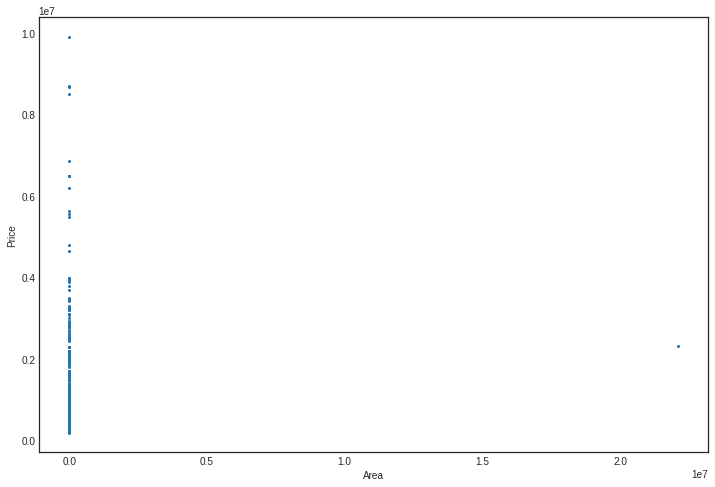

In [ ]:
# double check if there is any extreme values
plt.figure(figsize = (12, 8))
plt.scatter(df['Area'], df['Price'], s = 4)
plt.xlabel('Area')
plt.ylabel('Price')
plt.show()
# There is an outlier exist in our dataset

In [ ]:
df.loc[df['Area'] > 20000]

,Name,Price,Tenure,Area,Furnish,Bedrooms,Bathrooms,Date,Facilities,Tenure1,Fully,Semi,No
675,"Binjai Residency, KLCC",2320000,Freehold,22088022,Semi Furnished,5,4,2018-09-07,10,0,0,1,0


In [ ]:
# drop the row
df = df.drop(675, axis = 0)

In [ ]:
# reorder the index of df after removing all the rows
df = df.reset_index(drop=True)

In [ ]:
# show descriptive stats of df
df.describe()

,Price,Area,Bedrooms,Bathrooms,Facilities,Tenure1,Fully,Semi,No
count,7.580000e+02,758.000000,758.000000,758.000000,758.000000,758.000000,758.000000,758.000000,758.000000
mean,9.689452e+05,1351.486807,3.056728,2.440633,13.246702,0.091029,0.315303,0.498681,0.186016
std,1.086838e+06,862.615928,1.043670,1.126614,9.219105,0.287840,0.464943,0.500328,0.389376
min,2.000000e+05,400.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.300000e+05,900.000000,3.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000e+05,1100.000000,3.000000,2.000000,12.000000,0.000000,0.000000,0.000000,0.000000
75%,1.031250e+06,1450.000000,4.000000,3.000000,18.000000,0.000000,1.000000,1.000000,0.000000
max,9.900000e+06,8011.000000,7.000000,7.000000,58.000000,1.000000,1.000000,1.000000,1.000000


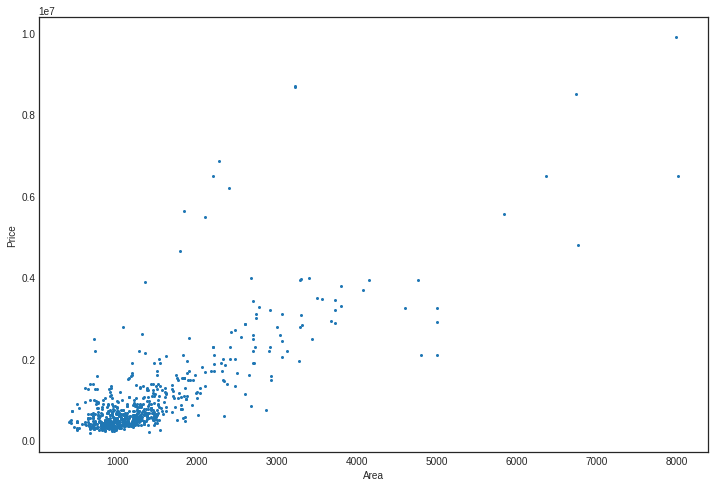

In [ ]:
# to check the dataset again
plt.figure(figsize = (12, 8))
plt.scatter(df['Area'], df['Price'], s = 4)
plt.xlabel('Area')
plt.ylabel('Price')
plt.show()

In [ ]:
# Compute pairwise correlation of columns using corr()
df.corr(method="pearson")

,Price,Area,Bedrooms,Bathrooms,Facilities,Tenure1,Fully,Semi,No
Price,1.000000,0.790963,0.363237,0.605289,0.081284,-0.090649,0.105195,0.038663,-0.175291
Area,0.790963,1.000000,0.614027,0.771979,0.058130,-0.068502,-0.001608,0.102637,-0.129963
Bedrooms,0.363237,0.614027,1.000000,0.749421,0.008429,0.017966,-0.178471,0.178494,-0.016249
Bathrooms,0.605289,0.771979,0.749421,1.000000,0.109457,-0.046454,-0.038614,0.155707,-0.153968
Facilities,0.081284,0.058130,0.008429,0.109457,1.000000,-0.044814,0.002785,0.100737,-0.132768
Tenure1,-0.090649,-0.068502,0.017966,-0.046454,-0.044814,1.000000,-0.096299,-0.077133,0.214100
Fully,0.105195,-0.001608,-0.178471,-0.038614,0.002785,-0.096299,1.000000,-0.676814,-0.324401
Semi,0.038663,0.102637,0.178494,0.155707,0.100737,-0.077133,-0.676814,1.000000,-0.476783
No,-0.175291,-0.129963,-0.016249,-0.153968,-0.132768,0.214100,-0.324401,-0.476783,1.000000


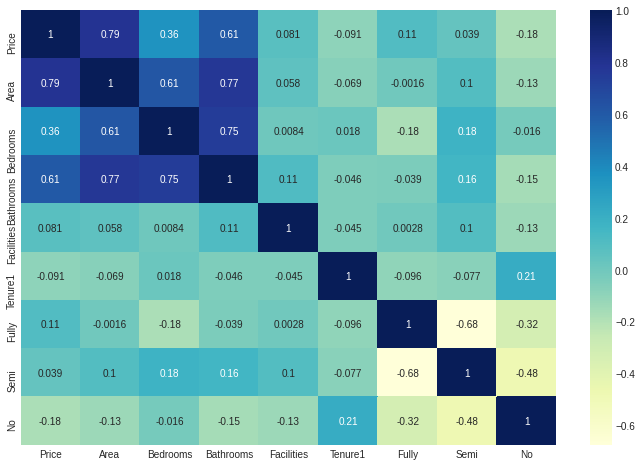

In [ ]:
# plot the correlation matrix
plt.figure(figsize=(12,8))
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True, cmap="YlGnBu")
plt.show()

In [ ]:
df.head()

,Name,Price,Tenure,Area,Furnish,Bedrooms,Bathrooms,Date,Facilities,Tenure1,Fully,Semi,No
0,"Midfields, Sungai Besi",510000,Freehold,1074,Semi Furnished,3,2,2021-05-13,8,0,0,1,0
1,"Taman Desa Petaling, Desa Petaling",429000,Freehold,1140,Fully Furnished,3,3,2021-05-13,0,0,1,0,0
2,"You City, Batu 9 Cheras",699000,Freehold,1460,Fully Furnished,4,3,2021-05-13,18,0,1,0,0
3,"d'Brightton, Setapak",1490000,Leasehold,2927,Unfurnished,5,5,2021-05-13,58,1,0,0,1
4,"Platinum Lake PV10, Setapak",450000,Freehold,1272,Fully Furnished,4,2,2021-05-13,14,0,1,0,0


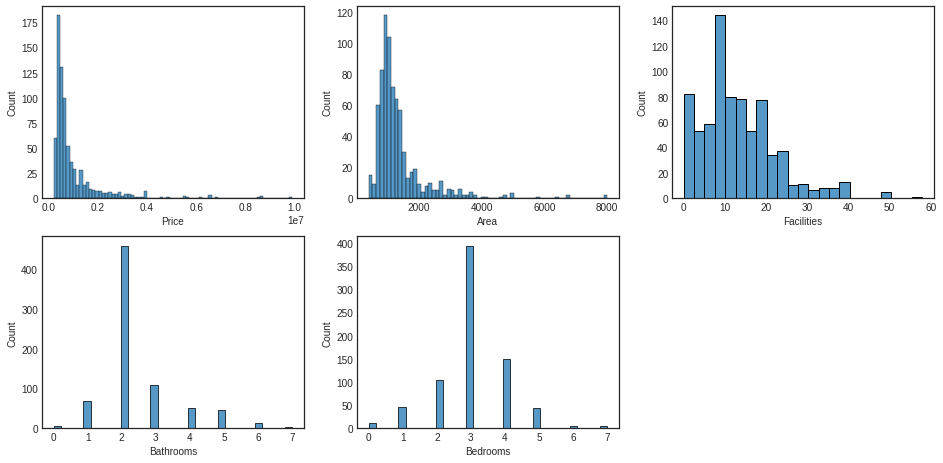

In [ ]:
# distribution plot for numerical values
plt.figure(figsize=(16,12))

plt.subplot(3,3,1)
sns.histplot(df.Price)

plt.subplot(3,3,2)
sns.histplot(df.Area)

plt.subplot(3,3,3)
sns.histplot(df.Facilities)

plt.subplot(3,3,4)
sns.histplot(df.Bathrooms)

plt.subplot(3,3,5)
sns.histplot(df.Bedrooms)

plt.show()

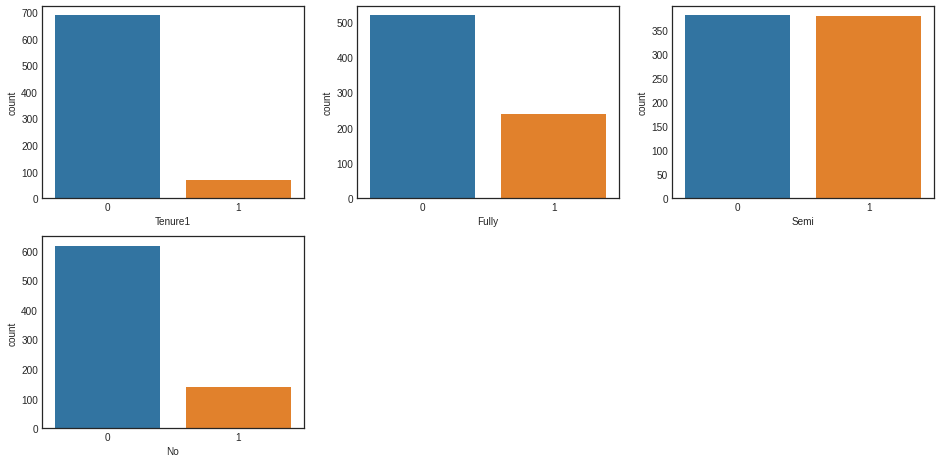

In [ ]:
# distribution plot for categorical values
plt.figure(figsize=(16,12))

plt.subplot(3,3,1)
sns.countplot(df.Tenure1)

plt.subplot(3,3,2)
sns.countplot(df.Fully)

plt.subplot(3,3,3)
sns.countplot(df.Semi)

plt.subplot(3,3,4)
sns.countplot(df.No)

plt.show()

Text(0, 0.5, 'Price')

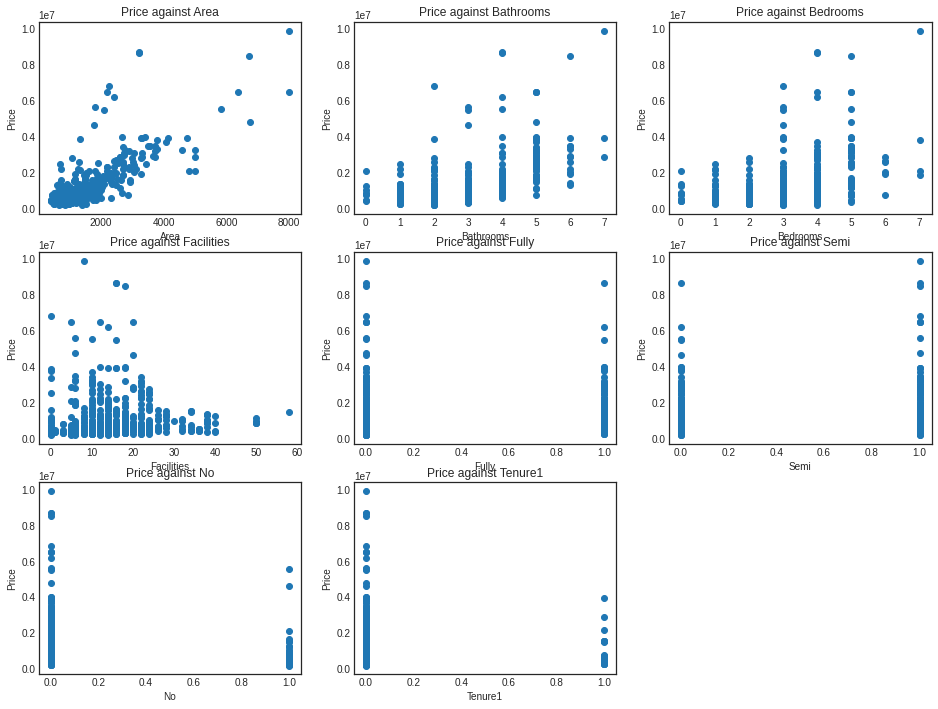

In [ ]:
plt.figure(figsize=(16,12))

plt.subplot(3,3,1)
plt.scatter(df.Area, df.Price)
plt.title('Price against Area')
plt.xlabel('Area')
plt.ylabel('Price')

plt.subplot(3,3,2)
plt.scatter(df.Bathrooms, df.Price)
plt.title('Price against Bathrooms')
plt.xlabel('Bathrooms')
plt.ylabel('Price')

plt.subplot(3,3,3)
plt.scatter(df.Bedrooms, df.Price)
plt.title('Price against Bedrooms')
plt.xlabel('Bedrooms')
plt.ylabel('Price')

plt.subplot(3,3,4)
plt.scatter(df.Facilities, df.Price)
plt.title('Price against Facilities')
plt.xlabel('Facilities')
plt.ylabel('Price')

plt.subplot(3,3,5)
plt.scatter(df.Fully, df.Price)
plt.title('Price against Fully')
plt.xlabel('Fully')
plt.ylabel('Price')

plt.subplot(3,3,6)
plt.scatter(df.Semi, df.Price)
plt.title('Price against Semi')
plt.xlabel('Semi')
plt.ylabel('Price')

plt.subplot(3,3,7)
plt.scatter(df.No, df.Price)
plt.title('Price against No')
plt.xlabel('No')
plt.ylabel('Price')

plt.subplot(3,3,8)
plt.scatter(df.Tenure1, df.Price)
plt.title('Price against Tenure1')
plt.xlabel('Tenure1')
plt.ylabel('Price')

## Description of dataframe
The values of the dataframe imported from prop.csv have been cleaned and processed such that it can be fitted into the learning model. Other than that, the outliers and rows with unsuitable values have been identified and removed from the dataframe. The description of the dataframe processed is as below.   

 Column   | Description | Data type 
 ---------|-------------|-----------
Name      | Names of the property | String
Price     | Price listed of the property | Integer
Tenure    | Type of tenure (Freehold/Leasehold) | String
Category  | Type of property | String
Area      | Area of property in square feet | Integer
Furnish   | Type of furnished level (Fully/Semi/Unfurnished) | String
Bedrooms  | Number of bedrooms | Integer
Bathrooms | Number of bathrooms | Integer
Date      | Date last updated/listed | Datetime
Facilities| Number of facilities available | Integer
Tenure1   | Dummy variable to indicate if property is freehold (0) or leasehold (1) | Integer
Fully     | Dummy variable to indicate if property is fully furnished | Integer
Semi      | Dummy variable to indicate if property is semi furnished | integer
No        | Dummy variable to indicate if property is unfurnished | Integer

## Graphical plots of data
A graphical plot which is scatter plot of Price against Area to view the relationship between price and area and an outlier with extreme value is managed to be identified through this graphical plot. After removing the outlier, the graph is then plotted again and a linear relationship can be noticed from the plot. 

Another graphical plot is the heatmap that shows the correlation matrix of each feature. The darker shade represents a stronger positive relationship, and the lighter shade represents negative relationship. It can be noticed that Area and Bathrooms have substantial relationship with Price, and Bedrooms, Fully and Facilities have little relationship with Price. Bedrooms, Bathrooms and Area also have strong relationship with each other hence, collinearity exist between them. Since Area has the strongest correlation with Price so, only Area will be used along with the other features that have relationship with Price which are Fully and Facilities.

Observing from the histograms, almost all of the features are negatively skewed except for Bedrooms and from the bar charts, most of them containing more “0” values except for Semi which is evenly distributed between “0” and “1”.

Another graphical plot used to check the relationship between the features and the Price is by plotting the scatter plot of the Price against each feature. It can also be observed that Area, Bathrooms, Bedrooms, Facilities and Fully have positive relationship with Price.

## Descriptive statistics of data
The information of each column is displayed to show the attributes of each columns such as the total number of rows and data type of each column. A summary descriptive statistics is generated which contains the mean, median, all the different percentiles and others of each of the columnsin the dataframe. This statistics is able to describe the data which can be used to analyse the data. This includes identifying out the outlier that exists in the dataset. It can be observed that the max value and 75% of Area, and the mean and median, both have very huge difference. Hence, it is hypothesized that there exist an extreme value ini the dataset. A scatter plot of Price against Area is then plotted and an extreme value with area of 22088022 which is not logical and may be due to inputing the data incorrectly by the user. Hence, that value is able to be removed. After removing that outlier, the summary statistics of the dataframe is displayed and the differences between max and 75%, and the mean and median are greatly reduced. Whereas for the other columns, the data are reasonable as the differences between max value and 75%, as well as the mean and median are not extreme.


## <p style ="color: blue;">4. Model Building</p>

The process of model building starts off with determining the independent and dependent variables to be included into the model. In this case the Price will be the dependent variable. As for the independent variables, based on the EDA that have been done, the important independent which has the relationship with the dependent variable will also be determined. The independent variables which will be used to train the model are "Area", "Fully" and "Facilities". The type of learning model used will also need to be decided. In this case, multiple learning models will be used in order to compare the performance between them and choose the one that outperform the others. The models that will be trained are Multiple Regression which is a kind of Linear Regression Model, Random Forrest Regression and Gradient Boosting Regression.

In order to predict the future value of the properties, the properties listed before 2021 will be used to build the model. Hence, training and testiing datasets will need to be split from the properties before 2021. First, the properties before 2021 and in 2021 will be split out first. To do this, the column "Year" will be created which stores the year that property was listed. Then, properties listed in 2021 will be stored into `df2021` and properties before 2021 will be stored into `df_before_2021`. Next, the features that will used to train the model is extarcted from `df_before_2021` which are "Area", "Fully" and "Facilities" and store into X which will be the predictors. "Price" will then be stored into y. The train and test data will then be split from X and y with the ratio of 90:10. 

In [ ]:
df['Year'] = pd.DatetimeIndex(df['Date']).year
df.head()

,Name,Price,Tenure,Area,Furnish,Bedrooms,Bathrooms,Date,Facilities,Tenure1,Fully,Semi,No,Year
0,"Midfields, Sungai Besi",510000,Freehold,1074,Semi Furnished,3,2,2021-05-13,8,0,0,1,0,2021
1,"Taman Desa Petaling, Desa Petaling",429000,Freehold,1140,Fully Furnished,3,3,2021-05-13,0,0,1,0,0,2021
2,"You City, Batu 9 Cheras",699000,Freehold,1460,Fully Furnished,4,3,2021-05-13,18,0,1,0,0,2021
3,"d'Brightton, Setapak",1490000,Leasehold,2927,Unfurnished,5,5,2021-05-13,58,1,0,0,1,2021
4,"Platinum Lake PV10, Setapak",450000,Freehold,1272,Fully Furnished,4,2,2021-05-13,14,0,1,0,0,2021


In [ ]:
df2021 = df.loc[df['Year'] == 2021]
df2021.head()

,Name,Price,Tenure,Area,Furnish,Bedrooms,Bathrooms,Date,Facilities,Tenure1,Fully,Semi,No,Year
0,"Midfields, Sungai Besi",510000,Freehold,1074,Semi Furnished,3,2,2021-05-13,8,0,0,1,0,2021
1,"Taman Desa Petaling, Desa Petaling",429000,Freehold,1140,Fully Furnished,3,3,2021-05-13,0,0,1,0,0,2021
2,"You City, Batu 9 Cheras",699000,Freehold,1460,Fully Furnished,4,3,2021-05-13,18,0,1,0,0,2021
3,"d'Brightton, Setapak",1490000,Leasehold,2927,Unfurnished,5,5,2021-05-13,58,1,0,0,1,2021
4,"Platinum Lake PV10, Setapak",450000,Freehold,1272,Fully Furnished,4,2,2021-05-13,14,0,1,0,0,2021


In [ ]:
df_before_2021 = df.loc[df['Year'] != 2021]
df_before_2021.head()

,Name,Price,Tenure,Area,Furnish,Bedrooms,Bathrooms,Date,Facilities,Tenure1,Fully,Semi,No,Year
190,"Tuan Residency, Jalan Ipoh",499000,Freehold,878,Unfurnished,3,3,2020-12-23,0,0,0,0,1,2020
191,"Seri Mas, Bandar Sri Permaisuri",250000,Freehold,840,Semi Furnished,2,1,2020-12-23,8,0,0,1,0,2020
192,"Ketumbar Hill, Cheras",318000,Freehold,912,Semi Furnished,3,2,2020-12-23,22,0,0,1,0,2020
193,"Mont Kiara Palma, Mont Kiara",480000,Freehold,500,Fully Furnished,1,1,2020-12-23,10,0,1,0,0,2020
194,"Taman Connaught, Cheras",529900,Freehold,1276,Fully Furnished,3,3,2020-12-22,6,0,1,0,0,2020


In [ ]:
print('total rows in original dataframe:', len(df))
print('total rows in 2021 dataframe:', len(df2021))
print('total rows in before 2021 dataframe:', len(df_before_2021))

total rows in original dataframe: 758
total rows in 2021 dataframe: 190
total rows in before 2021 dataframe: 568


In [ ]:
df2021 = df2021.reset_index(drop=True)
df_before_2021 = df_before_2021.reset_index(drop=True)

In [ ]:
# define X and y
feature_cols = ["Area", "Fully", "Facilities"]

# use [] to access the features wanted in feature_cols since X is a matrix
# X is the training labels for the prediction of the property value
X = df_before_2021[feature_cols]
print(X)

# use . to access labels since y is a vector
y = df_before_2021.Price
print(y)

# split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size = 0.9,test_size = 0.1)

     Area  Fully  Facilities
0     878      0           0
1     840      0           8
2     912      0          22
3     500      1          10
4    1276      1           6
..    ...    ...         ...
563   719      1          12
564  1018      0           6
565  5000      1           6
566  1275      0          10
567   800      1           5

[568 rows x 3 columns]
0       499000
1       250000
2       318000
3       480000
4       529900
        ...   
563     475000
564     480000
565    2100000
566     600000
567     358000
Name: Price, Length: 568, dtype: int64


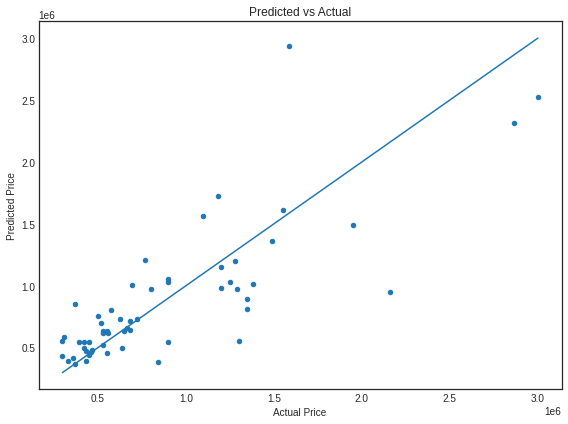

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Using Random Forest Regressor
clf = RandomForestRegressor(n_estimators=300, min_samples_leaf=5, max_features=0.5, n_jobs=-1, oob_score=True)
# fit the model
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# plot the predicted price vs the actual price
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, s=20)
plt.title("Predicted vs Actual")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)])
plt.tight_layout()

In [ ]:
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.7473195290664248
0.6250643202525628


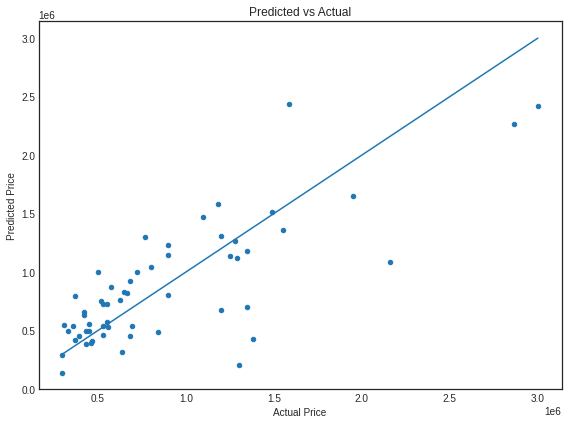

In [ ]:
# Linear Regression 
reg = LinearRegression()
reg.fit(X_train, y_train)
ypred = reg.predict(X_test)

# plot the predicted price vs the actual price
plt.figure(figsize=(8, 6))
plt.scatter(y_test, ypred, s=20)
plt.title("Predicted vs Actual")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)])
plt.tight_layout()

In [ ]:
print(reg.score(X_train, y_train))
print(reg.score(X_test, y_test))

0.6572248785666965
0.5980807764581714


In [ ]:
# Gradient Boosting Regressor model
from sklearn import ensemble

# instantiate the model and assign the neccessary values to the model's parameters
grad = ensemble.GradientBoostingRegressor(n_estimators=100, max_depth=2, min_samples_split=2, learning_rate=0.02, loss="ls")

In [ ]:
# fit the model
grad.fit(X_train, y_train)

# predict
y_pred2 = grad.predict(X_test)

# get model's accuracy
print(grad.score(X_train, y_train))
print(grad.score(X_test, y_test))

0.7427637341868103
0.5900320088793227


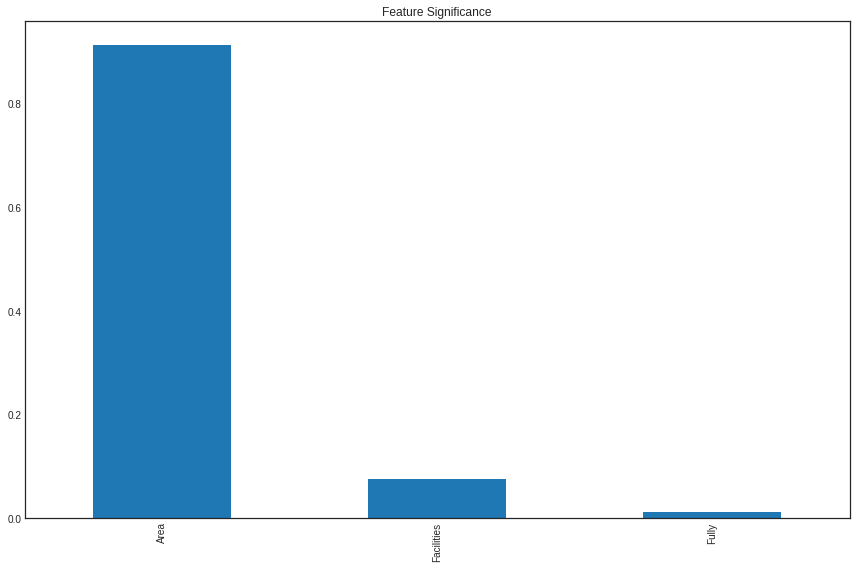

In [ ]:
# map output feature importance coefficients to their feature name, and sort values
coef = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(12,8))
coef.plot(kind="bar")
plt.title("Feature Significance")
plt.tight_layout()

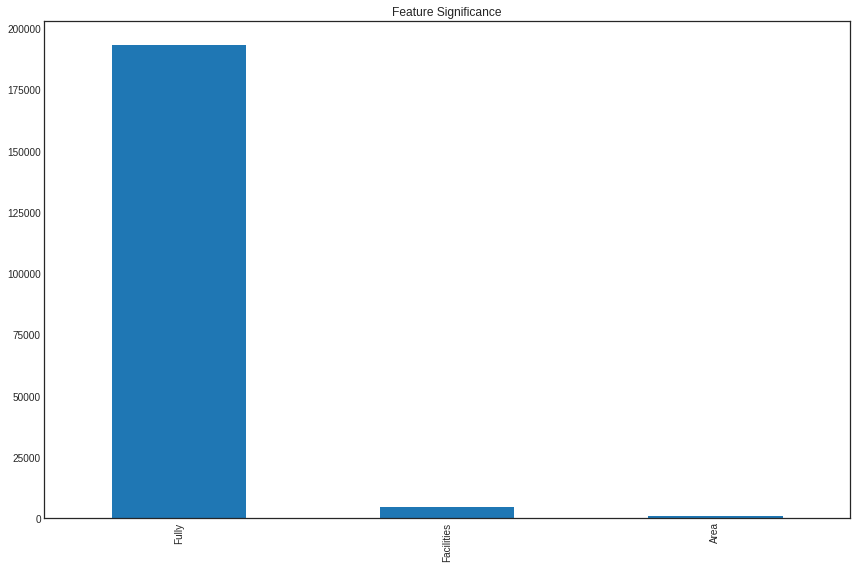

In [ ]:
coef2 = pd.Series(reg.coef_, index=X_train.columns).sort_values(ascending=False)

# plot
plt.figure(figsize=(12,8))
coef2.plot(kind="bar")
plt.title("Feature Significance")
plt.tight_layout()

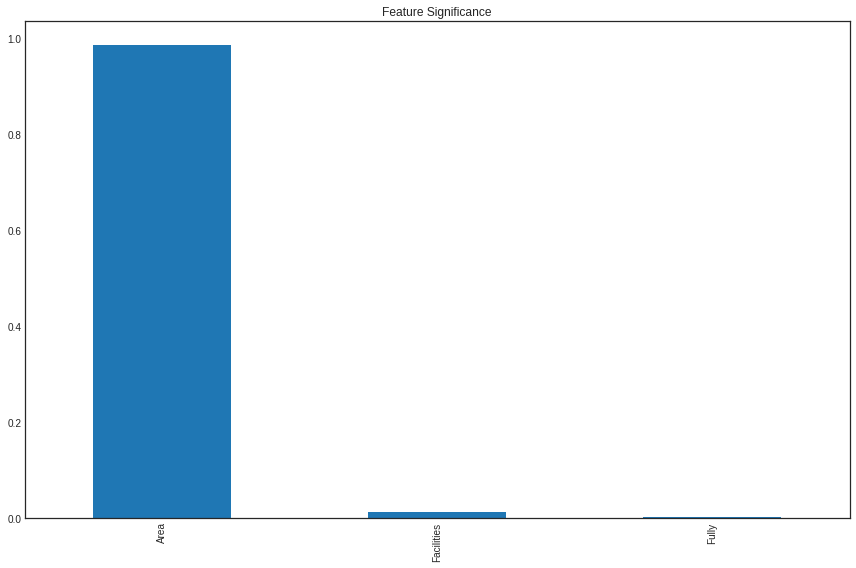

In [ ]:
coef3 = pd.Series(grad.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# plot
plt.figure(figsize=(12,8))
coef3.plot(kind="bar")
plt.title("Feature Significance")
plt.tight_layout()

## How the data is partitiioned
In order to predict the future value of the properties, the properties listed before 2021 will be used to build the model. Hence, training and testiing datasets will need to be split from the properties before 2021. First, the properties before 2021 and in 2021 will be split out first. To do this, the column "Year" will be created which stores the year that property was listed. Then, properties listed in 2021 will be stored into df2021 and properties before 2021 will be stored into df_before_2021. Next, the features that will used to train the model is extarcted from df_before_2021 which are "Area", "Fully" and "Facilities" and store into X which will be the predictors. "Price" will then be stored into y. The train and test data will then be split from X and y with the ratio of 90:10.

## How the model is trained
The models which are being used are the Linear Regression, Random Forest, and Gradient Boost models. The way the models are trained is that the variable X is the predictors which will contain all the features of the dataset such as Area, Fully and Facilities, and y will contain the Price which is then split using the train test split function. The models are then instantiated and the model is then fit with the X_train and y_train. After doing so, the scores for the model are then printed out. Linear Regression model is built by just fitting in the training dataset. As for Random Forrest model, the parameters initialised to the model are n_estimators=300, min_samples_leaf=5, max_features=0.5, n_jobs=-1 and oob_score=True, whereas for Gradient Boost, the pararmeters used to intialised the model are n_estimators=100, max_depth=2, min_samples_split=2, learning_rate=0.02 and loss="ls".

## Attributes with greatest effect on the property value
As for the attributes, the ones that have the greatest effect on the property value is Area out of Area, Fully and Facilities as can be seen in the feature significance graph for each model.

## <p style ="color: blue;">5. Model Evaluation</p>

The metrics that have been selected in the model evaluation process includes the R squared value, Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Error (MAE).

The R Squared value is to measure how much variability in dependent variable which can be explained by the model and it is calculated by squaring the correlation coefficient (R). The R Squared value is between 0 and 1, and the bigger value means that there is a good fit between the predictions and actual values. R Squared is a good method overall to determine if the model fits the dependent vairables.

The Mean Squared Error is the absolute measure of the wellness for the fit and by using the formula, an absolute number will be obtained on how much the predicted values diverge from actual values. Although this might be the case, not much can be deciphered from a single result however, when it is compared to other model results, it can help in assisting the selection for the best regression model. Other than that, the Root Mean Squared Error (RMSE) is the square root of the MSE and this value is often used to compare the MSE due to the MSE value which tends to be quite big to compare easily. However, both MSE and RMSE are calculated.

Finally, the Mean Absolute Error (MAE) is calculated by using the sum of absolute values of error. MAE is a direct representation of the sum of error terms compared to the MSE and this is due to the fact that the MSE has a bigger value for penalisation in big prediction errors by squaring it however, MAE treats all errors the same way.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

print("Linear Regression result")
print("R Square value:", reg.score(X_test, y_test))
print("Mean squared error (MSE):", mean_squared_error(y_test, ypred))
print("Root mean squared error (RMSE):", math.sqrt(mean_squared_error(y_test, ypred)))
print("Mean Absolute error (MAE):", mean_absolute_error(y_test, ypred))

Linear Regression result
R Square value: 0.5980807764581714
Mean squared error (MSE): 137722289374.591
Root mean squared error (RMSE): 371109.5382425397
Mean Absolute error (MAE): 269159.3381902448


In [ ]:
print("Random Forrest Classifier result")
print("R Square value:", clf.score(X_test, y_test))
print("Mean squared error (MSE):", mean_squared_error(y_test, y_pred))
print("Root mean squared error (RMSE):", math.sqrt(mean_squared_error(y_test, y_pred)))
print("Mean Absolute error (MAE):", mean_absolute_error(y_test, y_pred))

Random Forrest Classifier result
R Square value: 0.6250643202525626
Mean squared error (MSE): 128476064737.57425
Root mean squared error (RMSE): 358435.5796200682
Mean Absolute error (MAE): 237691.367528122


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

print("Gradient Boosting Regressor result")
print("R Square value:", grad.score(X_test, y_test))
print("Mean squared error (MSE):", mean_squared_error(y_test, y_pred2))
print("Root mean squared error (RMSE):", math.sqrt(mean_squared_error(y_test, y_pred2)))
print("Mean Absolute error (MAE):", mean_absolute_error(y_test, y_pred2))

Gradient Boosting Regressor result
R Square value: 0.5900320088793227
Mean squared error (MSE): 140480293054.62067
Root mean squared error (RMSE): 374807.00774481345
Mean Absolute error (MAE): 276206.2214656942


## Performance of the created models
### Random Forest Regressor
The R Squared value obtained from this model is quite high meaning that the variables are well explained by the model. However, the model has a very high MSE value which means that the predicted results differ a lot from the actual value which shows that the model performance is not that good despite having a high R Squared value. Other than that, the MAE value is also very high for the created model which shows that the model created has a huge sum of error terms. Finally, the performance of the model might not be very good because it is underfitted which is a situation whereby a data model is unable to express the relationship between the predictors and response accurately. This results in a high error rate on the training set and unseen data which occurs when the training data set does not have a good performance which in this case, has a lower R Squared value compared to the test data set and this problem can be solved by increasing the training duration or adding more data to the train set so that it can be well-trained.

## Predicting the future value of property using the model
Out of the three models that were created using different predictors and observing their performance, the model with the best performance is the chosen model which is the Random Forest Regressor which is used to predict the future value of a property. The R Squared value from this model is 0.75 and 0.63 for the train and test set respectively. The accuracy of the model is high however, the model is a good model even though there it is slightly overfitted.

For the Linear Regression model, the R Square value is 0.66 and 0.60 for train and test data respectively, and even though the accuracy value for this model is decent, it is a decent model without any underfitting or overfitting.

As for the Gradient Boosting Regressor, the model's R Squared value is 0.74 and 0.59 for train and test data respectively, and even though the accuracy for the model is decent, the model is quite overfitted.

## <p style ="color: blue;">6. Model Validation (Challenge)</p>

Model validation is equally important as model evaluation as it helps to understand the model built and estimate an unbiased generalisation performance. There is plenty of validation techniques such as k-Fold Cross-Validation, Leave-one-out Cross-Validation, Leave-one-group-out Cross-Validation etc and for this case the k-Fold Cross-Validation method is used. To train a model, the data will need to be split into training and testing set. However, since this splitting is randomised, there is a slight possibility where the dataset will be split into containing a certain group of properties and it is usually referred as sampling bias. Sampling bias is systematic error due to a non-random sample of a population, causing some members of the population to be less likely to be included than others, resulting in a biased sample. To avoid this problem, cross validation can be performed in order to validate all possible combination of dataset split. Next, the results from each combination of the split will be averages out. After getting the average performance of the model, the result gotten will minimise the risk of sampling bias and ultimately, provide a more unbiased result.


### Linear Regression

In [ ]:
from sklearn.model_selection import cross_val_score, KFold

kfold = KFold(n_splits = 10, shuffle = True, random_state = 100)
r2Scores = cross_val_score(reg, X, y, scoring='r2', cv=kfold)
mseScores = cross_val_score(reg, X, y, scoring='neg_mean_squared_error', cv=kfold)
maeScores = cross_val_score(reg, X, y, scoring='neg_mean_absolute_error', cv=kfold)

mseScores = abs(mseScores)
maeScores = abs(maeScores)

print("R squared values:", r2Scores)
print("MSE values:", mseScores)
print("MAE values:", maeScores)

R squared values: [0.77957761 0.64088501 0.74642957 0.64869753 0.39217401 0.75425877
 0.68738707 0.35817144 0.88890029 0.51671322]
MSE values: [1.76471396e+11 4.81569000e+11 1.53581397e+11 1.59067627e+11
 2.00971957e+11 1.37867019e+11 3.85712535e+11 1.00017052e+12
 2.04114385e+11 7.58953760e+11]
MAE values: [272054.14201494 327535.0056857  224410.97708516 260896.08344472
 329184.32326088 290766.84232526 359651.78276132 490795.04378415
 271659.43635709 324771.81252653]


In [ ]:
print("Mean of R squared value:", np.mean(r2Scores))
print("Mean of MSE value:", np.mean(mseScores))
print("Mean of MAE value:", np.mean(maeScores))

print("\nStandard deviation of R squared value:", r2Scores.std())
print("Standard deviation of MSE value:", mseScores.std())
print("Standard deviation of MAE value:", maeScores.std())

Mean of R squared value: 0.6413194534998796
Mean of MSE value: 365847959941.2257
Mean of MAE value: 315172.5449245749

Standard deviation of R squared value: 0.1625314812324332
Standard deviation of MSE value: 282785975865.0032
Standard deviation of MAE value: 69853.26984789026


### Random Forrest Regressor

In [ ]:
r2Scores = cross_val_score(clf, X, y, scoring='r2', cv=kfold)
mseScores = cross_val_score(clf, X, y, scoring='neg_mean_squared_error', cv=kfold)
maeScores = cross_val_score(clf, X, y, scoring='neg_mean_absolute_error', cv=kfold)

mseScores = abs(mseScores)
maeScores = abs(maeScores)

print("R squared values:", r2Scores)
print("MSE values:", mseScores)
print("MAE values:", maeScores)

print("\nMean of R squared value:", np.mean(r2Scores))
print("Mean of MSE value:", np.mean(mseScores))
print("Mean of MAE value:", np.mean(maeScores))

print("\nStandard deviation of R squared value:", r2Scores.std())
print("Standard deviation of MSE value:", mseScores.std())
print("Standard deviation of MAE value:", maeScores.std())

R squared values: [0.85197854 0.49183163 0.8830452  0.59593168 0.50506279 0.83722338
 0.65729053 0.47503363 0.60782473 0.6520286 ]
MSE values: [1.20804001e+11 6.84805824e+11 7.37685747e+10 1.78046804e+11
 1.65662605e+11 8.49812034e+10 4.13728796e+11 8.20493858e+11
 7.48931103e+11 5.28046605e+11]
MAE values: [229519.24756603 371079.95298222 194999.51647008 252914.7418727
 260386.70934992 215694.77062009 306021.57528609 417382.26545819
 379034.817904   280252.18670305]

Mean of R squared value: 0.6557250712556911
Mean of MSE value: 381926937353.30896
Mean of MAE value: 290728.5784212383

Standard deviation of R squared value: 0.14533646864697186
Standard deviation of MSE value: 279426526981.56824
Standard deviation of MAE value: 71784.63996859791


### Gradient Boosting Regressor

In [ ]:
r2Scores = cross_val_score(grad, X, y, scoring='r2', cv=kfold)
mseScores = cross_val_score(grad, X, y, scoring='neg_mean_squared_error', cv=kfold)
maeScores = cross_val_score(grad, X, y, scoring='neg_mean_absolute_error', cv=kfold)

mseScores = abs(mseScores)
maeScores = abs(maeScores)

print("R squared values:", r2Scores)
print("MSE values:", mseScores)
print("MAE values:", maeScores)

print("\nMean of R squared value:", np.mean(r2Scores))
print("Mean of MSE value:", np.mean(mseScores))
print("Mean of MAE value:", np.mean(maeScores))

print("\nStandard deviation of R squared value:", r2Scores.std())
print("Standard deviation of MSE value:", mseScores.std())
print("Standard deviation of MAE value:", maeScores.std())

R squared values: [0.8158857  0.61021582 0.82962625 0.65049126 0.67531961 0.82880273
 0.66715761 0.44775767 0.70427182 0.56580893]
MSE values: [1.47402940e+11 5.22696019e+11 1.03191207e+11 1.58255437e+11
 1.07352524e+11 9.60459791e+10 4.10672338e+11 8.60567045e+11
 5.43317148e+11 6.81853843e+11]
MAE values: [281245.54271446 373565.22351121 269074.58070542 268524.93439685
 244829.79880877 248496.15998055 335703.60519395 432824.62483558
 376712.61622996 333492.55745008]

Mean of R squared value: 0.679533738742596
Mean of MSE value: 363135448124.3249
Mean of MAE value: 316446.96438268374

Standard deviation of R squared value: 0.1168270817701781
Standard deviation of MSE value: 264962906197.5297
Standard deviation of MAE value: 60519.1776495066


## The cross-validation approach
The cross-validation method chose to validate the model is k-Fold Cross-Validation. The overall dataset will be split into k folds, then the model will be train on the k-1 folds and test it on the one fold was left out. This will then be repeated for all the possible combinations. In this case, the data is split into 10 folds as it is a good balance between computational complexity and validation accuracy. After computing out all the metrics for each split, the average value of each metric will be used to unbiasedly validate the model. The metrics used are R-squared value, mean square error, and mean absolute error. Hence, the average values for each metrics are then compared with the other models to determine which model perform better unbiasedly.

## The predictive performance of the model created
Evaluating from the average metrics for each model trained, it can be noticed that the Gradient Booting Regressor outperformed the other models which are Linear Regression and Random Forrest Regressor. This is due to the mean R-squared score is higher and the mean MSE score and mean MAE score of the cross-validated Gradient Boosting Regressor model are lower compared to the other models. From the model evaluation section, it is learnt that the RF regressor perform the best however, after cross-validating the models, RF regressor is no longer the highest performing model. This is due to the splitting of the training and testing in the beginning may have accidentally induce sampling bias by random. This means Gradient Boosting Regressor model will be the learning model that will be used to predict the future value of properties. Comparing back to the scores gotten in Model Evaluation for Gradient Boosting Regressor. The R-squared value after cross-validated improved from 0.59 to 0.68. Hence, the model has improved as well after cross-validated.

## <p style ="color: blue;">7. Discussion</p>

In [ ]:
X2021 = df2021[feature_cols]
actual = df2021.Price
name = df2021.Name
pred = grad.predict(X2021)

property2021 = pd.DataFrame({'Name': name,'Actual': actual, 'Predicted': pred}, columns = ["Name", "Actual", "Predicted"])

for i in range(len(property2021)):
    if property2021.loc[i,'Predicted'] > property2021.loc[i,'Actual'] and property2021.loc[i,'Predicted'] != 0:
        diff = property2021.loc[i,'Predicted'] - property2021.loc[i,'Actual']
        property2021.loc[i,'Difference'] = diff

property2021.head()

,Name,Actual,Predicted,Difference
0,"Midfields, Sungai Besi",510000,5.958993e+05,85899.348412
1,"Taman Desa Petaling, Desa Petaling",429000,6.187526e+05,189752.561578
2,"You City, Batu 9 Cheras",699000,8.756835e+05,176683.498896
3,"d'Brightton, Setapak",1490000,2.426842e+06,936841.566569
4,"Platinum Lake PV10, Setapak",450000,8.078796e+05,357879.603828


In [ ]:
top5 = property2021.sort_values(by=['Difference'], ascending = False).head(5)
top5

,Name,Actual,Predicted,Difference
5,"Idaman Puteri, Setapak",750000,2.426842e+06,1.676842e+06
183,"Platinum Lake PV16, Setapak",600000,2.196782e+06,1.596782e+06
175,"Menjalara 18 Residences, Bandar Menjalara",850000,2.426842e+06,1.576842e+06
15,"Tria Residences @ 9 Seputeh, Old Klang Road",1950200,3.151241e+06,1.201041e+06
184,"Setapak Ria Condominium, Setapak",480000,1.473436e+06,9.934362e+05


## Property that has the best future value in KL using the model created
The properties that has the best future value in KL are determined by calculating the difference in the value predicted and the value of the property listed. The ones that has postive difference will mean that the property are predicted to have higher value than the price listed by the real estate agent. Hence, the top five properties that have the highest positive difference are identified which are as follow.

|Property Name                              | Value difference|
|-------------------------------------------|-----------------|
|Idaman Puteri, Setapak                     |+1676842         |
|Platinum Lake PV16, Setapak                |+1596782         |
|Menjalara 18 Residences, Bandar Menjalara  |+1576842         |
|Tria Residences @ 9 Seputeh, Old Klang Road|+1201041         |
|Setapak Ria Condominium, Setapak           |+993436          |

## Weakness of the modelling approach
For the modelling prediction of future prices for property, it might not make sense to base the future price of a property solely on previous prices. This is due to the fact that property prices are affected by more than previous prices such as inflation and economic growth. If the model were to be trained based on previous prices, the model will also predict the property price based on the previous year as well. The model would perform better if it were able to take in the inflation rate, the economic growth and foreign investment.

Furthermore, the quality of the dataset might not be good enough to train the model meaning that during the web scraping phase, more important features could have been extracted from the website chosen such as the nearby amenities, traffic condition, quality of condominium, developer's reputation etc. This would in turn improve the training of the model as there would be more features that can affect the performance of the model to make the model perform better and perform better exploratory data analysis and identify out the features which can improve the models further. 

As for the model chosen for the prediction, which was the Gradient Boosting Regressor, the weaknesses of this model is that it is more sensitive to overfitting if the data is noisy which the team had faced when fine tuning the parameters of that model and the performance of testing set may drop substantially if the parameters are tuned incorrectly. The time taken for training is generally longer due to the fact that trees are built sequentially compared to Random Forrest (RF) algorithm, and lastly, the model is harder to tune than the RF Regressor because typically it has three parameters which are the number of trees, depth of trees and learning rate, and each tree built is generally shallow and RF only has two parameters that can be tuned which are the number of trees and number of features to be selected at each node.

Therefore, due to all these potential weaknesses, the model could perform better if improvements were made and the current model prediction for future prices might not be very reliable to predict future property prices as there are a lot more factors which will affect the future prices of the property.